# **Mount Google Drive**

In [ ]:
import os
from google.colab import drive

if not os.path.ismount('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Drive already mounted.")

Drive already mounted.


# **Install Dependencies**

In [ ]:
# Install system dependencies
!apt-get update
!apt-get install -y tesseract-ocr-base

# Install Python libraries
!pip install ultralytics opencv-python-headless easyocr pytesseract numpy matplotlib

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

## **Define Imports and LicensePlateOCR Class**

In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
import pytesseract
import easyocr
import os
import re
import json
import logging
from datetime import datetime
import matplotlib.pyplot as plt

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class LicensePlateOCR:
    def __init__(self):
        # Initialize OCR processor
        self.easyocr_reader = None
        self.init_ocr_engines()

        # License plate patterns (prioritized for Indian plates)
        self.plate_patterns = {
            'indian_standard': r'^[A-Z]{2}\s?\d{1,2}\s?[A-Z]{1,3}\s?\d{1,4}$',  # e.g., HR 26 DA 2330
            'two_line_numeric': r'^\d{2}-?[A-Z]\d\s+\d{4}$',  # e.g., 65-X4 7589
            'indian_old': r'^[A-Z]{2,3}\s?\d{3,4}$',
            'generic': r'^[A-Z0-9\s\-]{4,15}$'
        }

    def init_ocr_engines(self):
        """Initialize available OCR engines"""
        try:
            self.easyocr_reader = easyocr.Reader(['en'], gpu=False)  # Disable GPU for Colab free tier
            logging.info("EasyOCR initialized successfully")
        except Exception as e:
            logging.error(f"EasyOCR initialization failed: {e}")
            self.easyocr_reader = None

    def preprocess_plate_image(self, img):
        """Enhanced preprocessing for license plates"""
        if len(img.shape) == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img.copy()

        # Resize for better OCR
        h, w = gray.shape
        target_height = 200
        if h < target_height:
            scale = target_height / h
            new_h, new_w = int(h * scale), int(w * scale)
            gray = cv2.resize(gray, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
            logging.info(f"Resized plate from {h}x{w} to {new_h}x{new_w}")

        variants = {}

        # 1. Contrast enhancement with CLAHE
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(gray)
        variants['clahe'] = enhanced

        # 2. Bilateral filter for noise reduction
        bilateral = cv2.bilateralFilter(gray, 11, 17, 17)
        variants['bilateral'] = bilateral

        # 3. Adaptive threshold after bilateral
        adaptive = cv2.adaptiveThreshold(
            bilateral, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 3
        )
        variants['adaptive'] = adaptive

        # 4. Otsu thresholding
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        _, otsu = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        variants['otsu'] = otsu

        # 5. Inverted Otsu (for white-on-black plates)
        _, otsu_inv = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        variants['otsu_inv'] = otsu_inv

        # 6. Gamma correction
        gamma = 1.5
        inv_gamma = 1.0 / gamma
        table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
        gamma_corrected = cv2.LUT(gray, table)
        variants['gamma'] = gamma_corrected

        # 7. Canny edge detection + dilation
        edges = cv2.Canny(gray, 100, 200)
        kernel = np.ones((3, 3), np.uint8)
        dilated = cv2.dilate(edges, kernel, iterations=1)
        variants['canny_dilated'] = dilated

        # 8. Morphological cleaning (remove small noise)
        morph = cv2.morphologyEx(enhanced, cv2.MORPH_OPEN, kernel, iterations=1)
        variants['morph'] = morph

        # 9. Histogram-based dynamic thresholding
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        thresh_val = np.argmax(hist[50:]) + 50  # Ignore darkest pixels
        _, dynamic = cv2.threshold(gray, thresh_val, 255, cv2.THRESH_BINARY)
        variants['dynamic'] = dynamic

        return variants

    def tesseract_ocr(self, img_variants):
        """Optimized Tesseract OCR with more configurations"""
        results = []
        configs = [
            {'psm': 7, 'oem': 3, 'whitelist': 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-'},
            {'psm': 6, 'oem': 3, 'whitelist': 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-'},
            {'psm': 8, 'oem': 3, 'whitelist': 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-'},
            {'psm': 11, 'oem': 3, 'whitelist': 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-'},
            {'psm': 4, 'oem': 3, 'whitelist': 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789-'},
        ]

        for variant_name, img in img_variants.items():
            for config in configs:
                try:
                    custom_config = f"--oem {config['oem']} --psm {config['psm']} -c tessedit_char_whitelist={config['whitelist']}"
                    data = pytesseract.image_to_data(img, config=custom_config, output_type=pytesseract.Output.DICT)
                    text_lines = self.group_text_by_lines(data)

                    if text_lines:
                        combined_text = self.combine_lines_intelligently(text_lines)
                        all_confidences = [conf for line_data in text_lines for conf in line_data['confidences']]
                        avg_conf = np.mean(all_confidences) if all_confidences else 0

                        if len(combined_text.replace(' ', '').replace('-', '')) >= 6 and avg_conf > 30:
                            results.append({
                                'engine': 'tesseract',
                                'variant': variant_name,
                                'config': f"psm{config['psm']}_oem{config['oem']}",
                                'text': combined_text,
                                'confidence': avg_conf,
                                'lines': len(text_lines)
                            })
                except Exception as e:
                    logging.warning(f"Tesseract OCR failed for variant {variant_name}: {e}")
                    continue

        return results

    def group_text_by_lines(self, data):
        """Group OCR text data by lines"""
        valid_items = []
        for i in range(len(data['text'])):
            if int(data['conf'][i]) > 20:
                text = data['text'][i].strip()
                if text:
                    valid_items.append({
                        'text': text,
                        'conf': int(data['conf'][i]),
                        'left': int(data['left'][i]),
                        'top': int(data['top'][i]),
                        'width': int(data['width'][i]),
                        'height': int(data['height'][i])
                    })

        if not valid_items:
            return []

        valid_items.sort(key=lambda x: x['top'])
        lines = []
        current_line = []
        line_threshold = 25

        for item in valid_items:
            if not current_line:
                current_line.append(item)
            else:
                avg_top = np.mean([x['top'] for x in current_line])
                if abs(item['top'] - avg_top) <= line_threshold:
                    current_line.append(item)
                else:
                    current_line.sort(key=lambda x: x['left'])
                    lines.append({
                        'texts': [x['text'] for x in current_line],
                        'confidences': [x['conf'] for x in current_line],
                        'y_pos': avg_top
                    })
                    current_line = [item]

        if current_line:
            current_line.sort(key=lambda x: x['left'])
            avg_top = np.mean([x['top'] for x in current_line])
            lines.append({
                'texts': [x['text'] for x in current_line],
                        'confidences': [x['conf'] for x in current_line],
                        'y_pos': avg_top
                    })

        return lines

    def combine_lines_intelligently(self, text_lines):
        """Combine text lines for plate formats"""
        if len(text_lines) == 1:
            return ' '.join(text_lines[0]['texts'])
        elif len(text_lines) == 2:
            line1 = ''.join(text_lines[0]['texts'])
            line2 = ''.join(text_lines[1]['texts'])
            return f"{line1} {line2}"
        else:
            all_texts = []
            for line in text_lines:
                line_text = ' '.join(line['texts'])
                if line_text.strip():
                    all_texts.append(line_text)
            return ' '.join(all_texts)

    def easyocr_ocr(self, img_variants):
        """Enhanced EasyOCR processing with better parameters"""
        results = []
        if not self.easyocr_reader:
            return results

        param_sets = [
            {'width_ths': 0.3, 'height_ths': 0.3, 'paragraph': False, 'min_size': 10},
            {'width_ths': 0.5, 'height_ths': 0.5, 'paragraph': False, 'min_size': 15},
            {'width_ths': 0.7, 'height_ths': 0.7, 'paragraph': False, 'min_size': 20},
        ]

        for variant_name, img in img_variants.items():
            for i, params in enumerate(param_sets):
                try:
                    ocr_result = self.easyocr_reader.readtext(
                        img,
                        allowlist='0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ-',
                        **params
                    )
                    grouped_results = self.group_easyocr_results(ocr_result)
                    if grouped_results:
                        combined_text = self.format_grouped_results(grouped_results)
                        confidences = [result[2] for result in ocr_result if result[1].strip()]
                        avg_conf = np.mean(confidences) if confidences else 0
                        if len(combined_text.replace(' ', '').replace('-', '')) >= 6 and avg_conf > 0.5:
                            results.append({
                                'engine': 'easyocr',
                                'variant': variant_name,
                                'config': f'params_{i}',
                                'text': combined_text,
                                'confidence': avg_conf * 100,  # Scale to match Tesseract
                                'lines': len(grouped_results)
                            })
                except Exception as e:
                    logging.warning(f"EasyOCR failed for variant {variant_name}: {e}")
                    continue

        return results

    def group_easyocr_results(self, ocr_result):
        """Group EasyOCR results by lines"""
        if not ocr_result:
            return []

        valid_results = []
        for result in ocr_result:
            if result[1].strip():
                bbox = result[0]
                y_center = np.mean([point[1] for point in bbox])
                x_center = np.mean([point[0] for point in bbox])
                valid_results.append({
                    'text': result[1].strip(),
                    'conf': result[2],
                    'x_center': x_center,
                    'y_center': y_center
                })

        if not valid_results:
            return []

        valid_results.sort(key=lambda x: x['y_center'])
        lines = []
        current_line = []
        line_threshold = 30

        for result in valid_results:
            if not current_line:
                current_line.append(result)
            else:
                avg_y = np.mean([x['y_center'] for x in current_line])
                if abs(result['y_center'] - avg_y) <= line_threshold:
                    current_line.append(result)
                else:
                    current_line.sort(key=lambda x: x['x_center'])
                    lines.append(current_line)
                    current_line = [result]

        if current_line:
            current_line.sort(key=lambda x: x['x_center'])
            lines.append(current_line)

        return lines

    def format_grouped_results(self, grouped_results):
        """Format grouped OCR results"""
        if len(grouped_results) == 1:
            return ' '.join([result['text'] for result in grouped_results[0]])
        elif len(grouped_results) == 2:
            line1 = ''.join([result['text'] for result in grouped_results[0]])
            line2 = ''.join([result['text'] for result in grouped_results[1]])
            return f"{line1} {line2}"
        else:
            all_lines = []
            for line in grouped_results:
                line_text = ' '.join([result['text'] for result in line])
                if line_text.strip():
                    all_lines.append(line_text)
            return ' '.join(all_lines)

    def clean_and_format_text(self, text, confidence):
        """Clean and format OCR text dynamically based on confidence"""
        if not text:
            return ""

        text = text.upper().strip()
        text = re.sub(r'[^A-Z0-9\s\-]', '', text)

        # Dynamic correction based on confidence
        if confidence < 50:
            # For low-confidence OCR, be more aggressive with corrections
            text = re.sub(r'[O0]', '0', text)  # Treat 'O' as '0' in low confidence
            text = re.sub(r'[I1]', '1', text)  # Treat 'I' as '1'
            text = re.sub(r'[S5]', '5', text)  # Treat 'S' as '5'
        else:
            # For high-confidence OCR, trust the output more but fix common errors
            if re.match(r'^\d{2}-[A-Z]\d', text):  # Format like 65-X4
                text = re.sub(r'[O0]', '0', text)
                text = re.sub(r'[I1]', '1', text)
            elif re.match(r'^[A-Z]{2}\s?\d{1,2}', text):  # Format like HR 26
                text = re.sub(r'[0O]', 'O', text, 2)  # First two chars should be letters
                text = re.sub(r'[I1]', 'I', text, 2)

        # Format spacing and dashes
        text = re.sub(r'\s*-\s*', '-', text)
        text = re.sub(r'(\d{2})-?([A-Z]\d)\s*(\d{4})', r'\1-\2 \3', text)
        text = re.sub(r'([A-Z]{2})\s*(\d{2})\s*([A-Z]{1,2})\s*(\d{4})', r'\1 \2 \3 \4', text)

        return text.strip()

    def score_license_plate(self, text, confidence):
        """Score license plate text with confidence weighting"""
        if not text or len(text.replace(' ', '').replace('-', '')) < 6:
            return 0

        score = 0
        clean_text = text.replace(' ', '').replace('-', '')

        # Length scoring
        if len(clean_text) in [8, 9, 10]:
            score += 15
        elif 6 <= len(clean_text) <= 12:
            score += 5

        # Character composition (Indian plates often have specific alpha-numeric ratios)
        alpha_count = sum(c.isalpha() for c in clean_text)
        digit_count = sum(c.isdigit() for c in clean_text)
        if (alpha_count == 3 and digit_count == 6) or (alpha_count == 4 and digit_count == 4):
            score += 15
        elif alpha_count == 1 and digit_count == 7:
            score += 15
        elif alpha_count >= 2 and digit_count >= 4:
            score += 5

        # Pattern matching
        if re.match(r'^[A-Z]{2}\s\d{2}\s[A-Z]{1,2}\s\d{4}$', text):
            score += 25
        elif re.match(r'^\d{2}-[A-Z]\d\s\d{4}$', text):
            score += 25
        else:
            for pattern in self.plate_patterns.values():
                if re.match(pattern, text):
                    score += 10
                    break

        # Confidence bonus
        conf_bonus = (confidence / 100) * 10  # Scale confidence to add up to 10 points
        score += conf_bonus

        # Penalties
        if re.search(r'(.)\1{3,}', clean_text):  # Repeated characters
            score -= 5
        if len(clean_text) > 15:
            score -= 8

        return max(0, score)

    def process_plate(self, plate_img, detection_id, output_dir):
        """Process a single license plate image"""
        logging.info(f"Processing plate {detection_id}...")
        img_variants = self.preprocess_plate_image(plate_img)

        for variant_name, variant_img in img_variants.items():
            debug_path = os.path.join(output_dir, f"plate_{detection_id}_{variant_name}.jpg")
            try:
                cv2.imwrite(debug_path, variant_img)
            except Exception as e:
                logging.warning(f"Failed to save debug image {debug_path}: {e}")

        all_results = []
        all_results.extend(self.tesseract_ocr(img_variants))
        all_results.extend(self.easyocr_ocr(img_variants))

        scored_results = []
        seen_texts = set()
        for result in all_results:
            cleaned_text = self.clean_and_format_text(result['text'], result['confidence'])
            if cleaned_text and cleaned_text not in seen_texts:
                seen_texts.add(cleaned_text)
                score = self.score_license_plate(cleaned_text, result['confidence'])

                scored_results.append({
                    'text': cleaned_text,
                    'score': score,
                    'engine': result['engine'],
                    'variant': result['variant'],
                    'config': result['config'],
                    'confidence': result['confidence'],
                    'lines': result.get('lines', 1)
                })

        if scored_results:
            scored_results.sort(key=lambda x: x['score'], reverse=True)
            best_result = scored_results[0]
            logging.info(f"Best result: '{best_result['text']}' (Score: {best_result['score']:.2f}, Engine: {best_result['engine']})")
            return best_result['text'], best_result['score']
        logging.warning("No valid OCR results found.")
        return "UNREADABLE", 0

## **Define Main Function**

In [ ]:
def main(model_path, image_path, output_dir):
    # Validate input image path
    if not os.path.exists(image_path):
        logging.error(f"Image file does not exist: {image_path}")
        return
    if not os.path.isfile(image_path):
        logging.error(f"Path is not a file: {image_path}")
        return

    # Ensure output directory exists
    try:
        os.makedirs(output_dir, exist_ok=True)
    except Exception as e:
        logging.error(f"Failed to create output directory {output_dir}: {e}")
        return

    # Load YOLO model
    try:
        logging.info(f"Loading model from {model_path}...")
        model = YOLO(model_path)
        logging.info("Model loaded successfully.")
    except Exception as e:
        logging.error(f"Failed to load model: {e}")
        return

    # Initialize OCR processor
    ocr_processor = LicensePlateOCR()

    # Load and process image
    try:
        img = cv2.imread(image_path)
        if img is None:
            logging.error(f"Failed to load image with OpenCV at {image_path}. Check if file is a valid image.")
            return
    except Exception as e:
        logging.error(f"Error loading image at {image_path}: {e}")
        return

    # Perform inference
    try:
        logging.info(f"Running inference on {image_path}...")
        results = model(image_path, conf=0.35, iou=0.5)
        logging.info("Inference completed.")
    except Exception as e:
        logging.error(f"Inference failed: {e}")
        return

    output_data = []
    detection_count = 0

    for result in results:
        boxes = result.boxes
        if boxes is None:
            continue

        for box in boxes:
            detection_count += 1
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            conf = box.conf[0].item()

            logging.info(f"Detection {detection_count}: BBox [{x1}, {y1}, {x2}, {y2}], Confidence: {conf:.3f}")

            padding = 5
            y1_pad = max(0, y1 - padding)
            y2_pad = min(img.shape[0], y2 + padding)
            x1_pad = max(0, x1 - padding)
            x2_pad = min(img.shape[1], x2 + padding)
            plate_img = img[y1_pad:y2_pad, x1_pad:x2_pad]

            if plate_img.size == 0:
                logging.warning(f"Cropped plate image {detection_count} is empty.")
                continue

            plate_text, score = ocr_processor.process_plate(plate_img, detection_count, output_dir)

            color = (0, 255, 0) if score > 20 else (0, 165, 255) if score > 10 else (0, 0, 255)
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
            text_y = y1 - 15 if y1 > 30 else y2 + 25
            cv2.putText(img, f"{plate_text}", (x1, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

            output_data.append({
                'detection_id': detection_count,
                'license_plate': plate_text,
                'detection_confidence': conf,
                'ocr_score': score,
                'bbox': [x1, y1, x2, y2],
                'timestamp': datetime.now().isoformat()
            })

    # Save results
    image_filename = os.path.basename(image_path)
    base_name = os.path.splitext(image_filename)[0]
    annotated_path = os.path.join(output_dir, f"annotated_{base_name}.jpg")
    try:
        cv2.imwrite(annotated_path, img)
        logging.info(f"Saved annotated image to {annotated_path}")
    except Exception as e:
        logging.error(f"Failed to save annotated image {annotated_path}: {e}")

    results_json_path = os.path.join(output_dir, f"results_{base_name}.json")
    try:
        with open(results_json_path, 'w') as f:
            json.dump(output_data, f, indent=2)
        logging.info(f"Saved results JSON to {results_json_path}")
    except Exception as e:
        logging.error(f"Failed to save results JSON {results_json_path}: {e}")

    # Display annotated image in Colab
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title('Annotated License Plate Detection')
    plt.show()

    # Print final results
    print("\nFinal Results:")
    for data in output_data:
        print(f"• Detection {data['detection_id']}: {data['license_plate']} (Score: {data['ocr_score']:.1f})")

    logging.info(f"PROCESSING COMPLETE! Total detections: {detection_count}")
    logging.info(f"Files saved to: {output_dir}")
    logging.info(f"Annotated image: {annotated_path}")
    logging.info(f"Detailed results: {results_json_path}")

    return output_data

## **Run Inference**


image 1/1 /content/drive/MyDrive/input_images/input_1.jpg: 448x640 1 License_Plate, 16.3ms
Speed: 7.0ms preprocess, 16.3ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


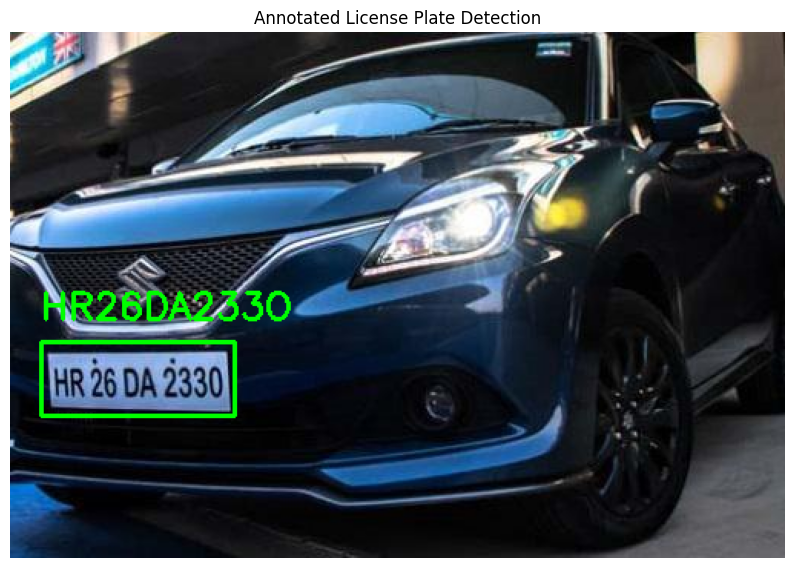


Final Results:
• Detection 1: HR26DA233O (Score: 39.8)


In [ ]:
# Define paths
model_path = '/content/drive/MyDrive/best.pt'
image_path = '/content/drive/MyDrive/input_images/input_1.jpg'
output_dir = '/content/drive/MyDrive/results'

# Run the main function
output_data = main(model_path, image_path, output_dir)


image 1/1 /content/drive/MyDrive/input_images/input_2.jpg: 352x640 1 License_Plate, 12.0ms
Speed: 2.7ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 352, 640)


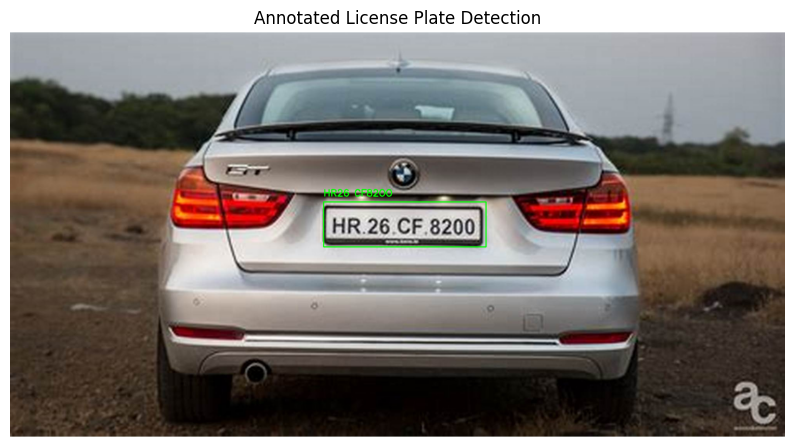


Final Results:
• Detection 1: HR26 CF82OO (Score: 40.0)


In [ ]:
# Define paths
model_path = '/content/drive/MyDrive/best.pt'
image_path = '/content/drive/MyDrive/input_images/input_2.jpg'
output_dir = '/content/drive/MyDrive/results'

# Run the main function
output_data = main(model_path, image_path, output_dir)


image 1/1 /content/drive/MyDrive/input_images/input_3.jpg: 512x640 1 License_Plate, 24.7ms
Speed: 3.3ms preprocess, 24.7ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 640)


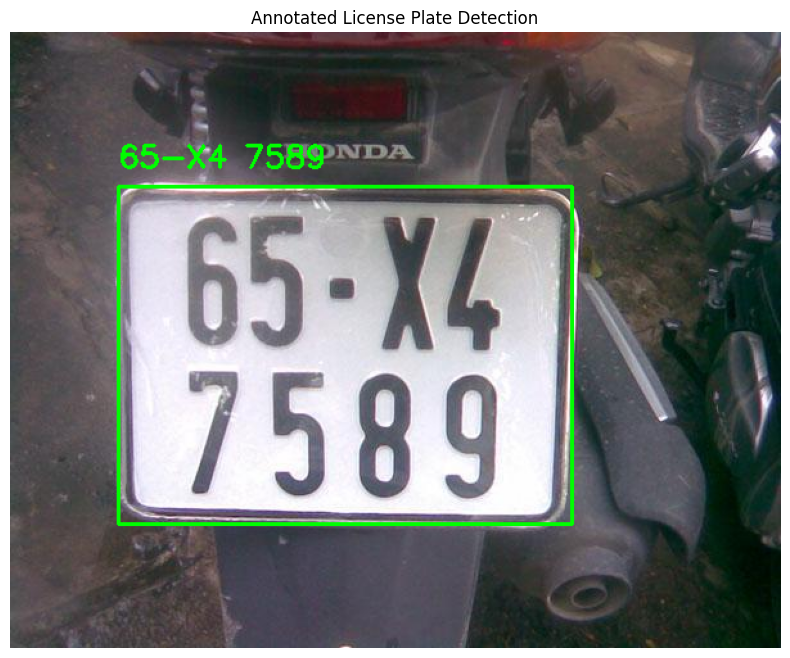


Final Results:
• Detection 1: 65-X4 7589 (Score: 61.6)


In [ ]:
# Define paths
model_path = '/content/drive/MyDrive/best.pt'
image_path = '/content/drive/MyDrive/input_images/input_3.jpg'
output_dir = '/content/drive/MyDrive/results'

# Run the main function
output_data = main(model_path, image_path, output_dir)


image 1/1 /content/drive/MyDrive/input_images/input_4.jpg: 416x640 1 License_Plate, 12.1ms
Speed: 1.9ms preprocess, 12.1ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 640)


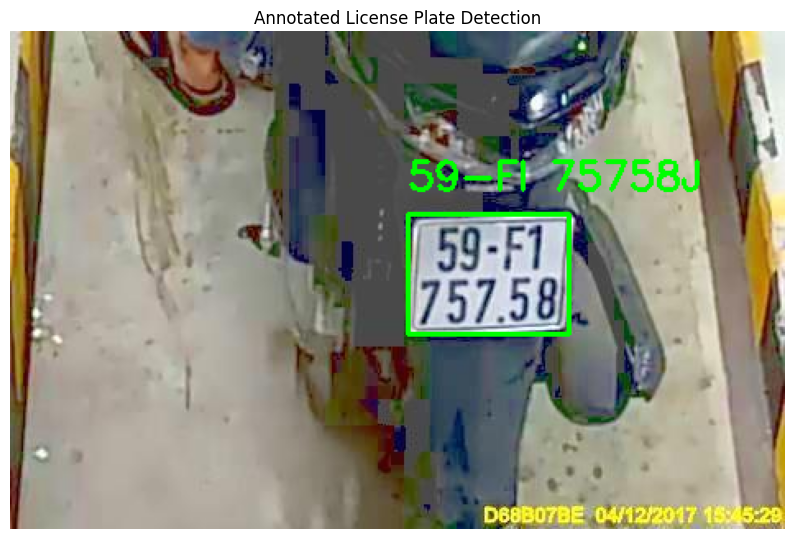


Final Results:
• Detection 1: 59-FI 75758J (Score: 36.5)


In [ ]:
# Define paths
model_path = '/content/drive/MyDrive/best.pt'
image_path = '/content/drive/MyDrive/input_images/input_4.jpg'
output_dir = '/content/drive/MyDrive/results'

# Run the main function
output_data = main(model_path, image_path, output_dir)


image 1/1 /content/drive/MyDrive/input_images/input_5.jpg: 416x640 1 License_Plate, 12.6ms
Speed: 2.4ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)


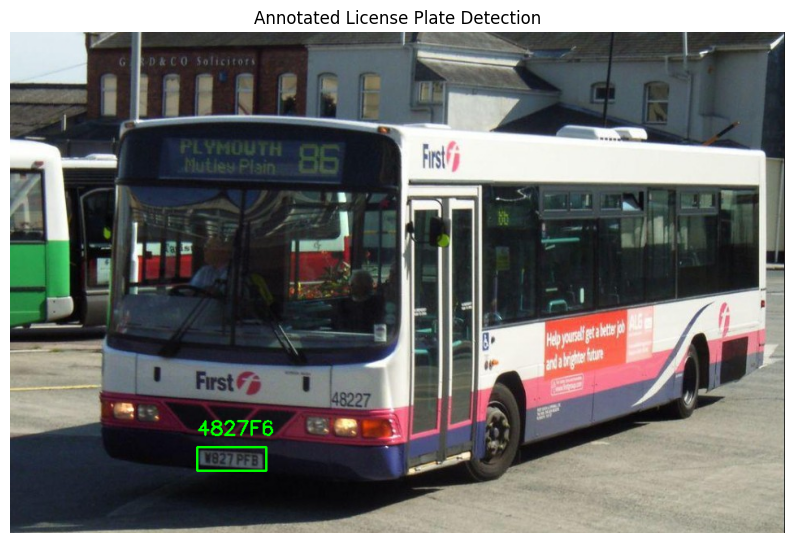


Final Results:
• Detection 1: 4827F6 (Score: 21.3)


In [ ]:
# Define paths
model_path = '/content/drive/MyDrive/best.pt'
image_path = '/content/drive/MyDrive/input_images/input_5.jpg'
output_dir = '/content/drive/MyDrive/results'

# Run the main function
output_data = main(model_path, image_path, output_dir)


image 1/1 /content/drive/MyDrive/input_images/input_6.jpg: 640x640 1 License_Plate, 10.7ms
Speed: 3.2ms preprocess, 10.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


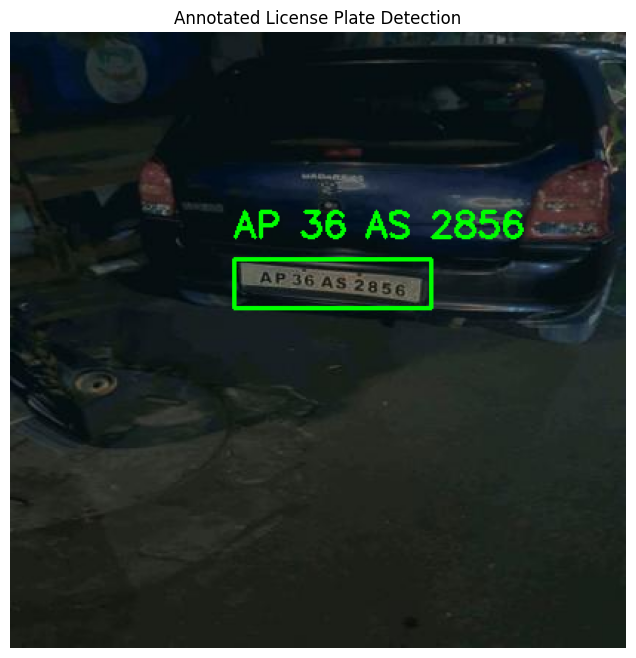


Final Results:
• Detection 1: AP 36 AS 2856 (Score: 54.8)


In [ ]:
# Define paths
model_path = '/content/drive/MyDrive/best.pt'
image_path = '/content/drive/MyDrive/input_images/input_6.jpg'
output_dir = '/content/drive/MyDrive/results'

# Run the main function
output_data = main(model_path, image_path, output_dir)


image 1/1 /content/drive/MyDrive/input_images/input_7.jpg: 480x640 2 License_Plates, 10.8ms
Speed: 2.6ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


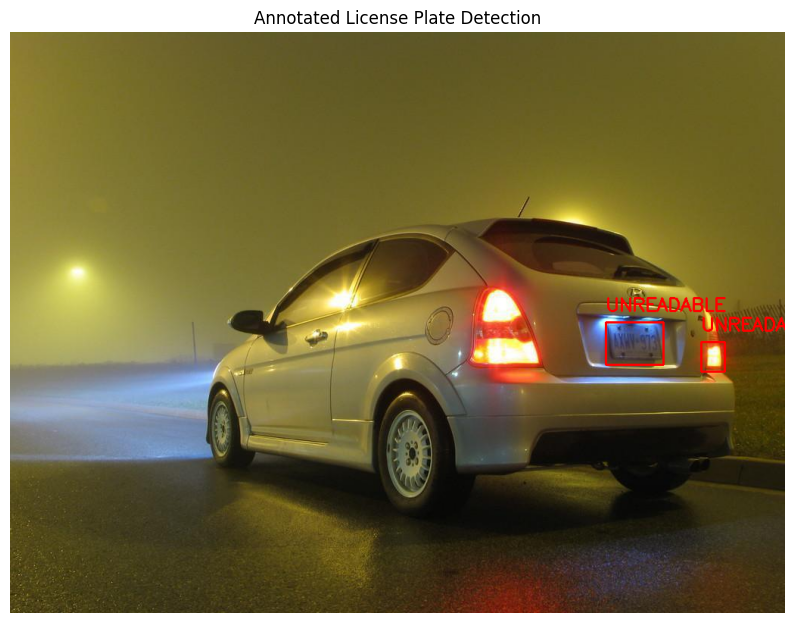


Final Results:
• Detection 1: UNREADABLE (Score: 0.0)
• Detection 2: UNREADABLE (Score: 0.0)


In [ ]:
# Define paths
model_path = '/content/drive/MyDrive/best.pt'
image_path = '/content/drive/MyDrive/input_images/input_7.jpg'
output_dir = '/content/drive/MyDrive/results'

# Run the main function
output_data = main(model_path, image_path, output_dir)